In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.objectives import categorical_crossentropy
from keras.datasets import mnist

Using Theano backend.
Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 75.0% of memory, CuDNN 4007)
/usr/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
%time (X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

CPU times: user 1.15 s, sys: 565 ms, total: 1.71 s
Wall time: 1.71 s
(60000, 'train samples')
(10000, 'test samples')


In [3]:
%time P = np.load('P.npy') # load pre-computed joint probabilities
batch_size = P.shape[1]

CPU times: user 899 µs, sys: 1.41 s, total: 1.41 s
Wall time: 1.41 s


In [22]:
from keras import backend as K

# P is the joint probabilities for this batch (Keras loss functions call this y_true)
# activations is the low-dimensional output (Keras loss functions call this y_pred)
def tsne(P, activations):
#     d = K.shape(activations)[1]
    d = 2 # TODO: should set this automatically, but the above is very slow for some reason
    n = batch_size # TODO: should set this automatically
    v = d - 1.
    eps = K.variable(10e-15) # needs to be at least 10e-8 to get anything after Q /= K.sum(Q)
    sum_act = K.sum(K.square(activations), axis=1)
    Q = K.reshape(sum_act, [-1, 1]) + -2 * K.dot(activations, K.transpose(activations))
    Q = (sum_act + Q) / v
    Q = K.pow(1 + Q, -(v + 1) / 2)
    Q *= K.variable(1 - np.eye(n))
    Q /= K.sum(Q)
    Q = K.maximum(Q, eps)
    C = K.log((P + eps) / (Q + eps))
    C = K.sum(P * C)
    return C

In [23]:
model = Sequential()
model.add(Dense(500, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(500))
model.add(Activation('relu'))
model.add(Dense(2000))
model.add(Activation('relu'))
model.add(Dense(2))
# model.build()
# print model.summary()

sgd = SGD(lr=0.1)
%time model.compile(loss=tsne, optimizer=sgd)

CPU times: user 3.35 s, sys: 408 ms, total: 3.76 s
Wall time: 3.77 s


In [24]:
%matplotlib inline
from matplotlib import pyplot as plt

import gc
!mkdir -p plotter
class Plotter(keras.callbacks.Callback):        
    def on_epoch_end(self, epoch, logs={}):
        prediction = self.model.predict(X_test)
        fig = plt.figure(figsize=(8,8))
        plt.scatter(prediction[:,0], prediction[:,1], alpha=1, marker='o', s=3, edgecolor='', c=y_test)
        ax = fig.gca()
        ax.set_autoscale_on(False)
        fig.tight_layout()
#         plt.xlim([-30,30])
#         plt.ylim([-30,30])
        plt.savefig('plotter/%04d.png' % (epoch+1), pad_inches=0)
        plt.close()
        gc.collect()

In [25]:
Y_train = P.reshape(X_train.shape[0], -1)
print(X_train.shape)
print(Y_train.shape)

(60000, 784)
(60000, 5000)


In [ ]:
model.fit(X_train, Y_train,
          batch_size=batch_size,
          callbacks=[Plotter()],
          shuffle=False,
          nb_epoch=500,
          verbose=1)

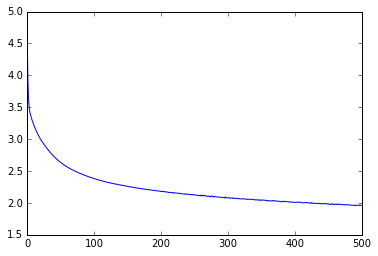

In [28]:
plt.plot(loss)

CPU times: user 1.12 s, sys: 8.26 ms, total: 1.13 s
Wall time: 1.14 s


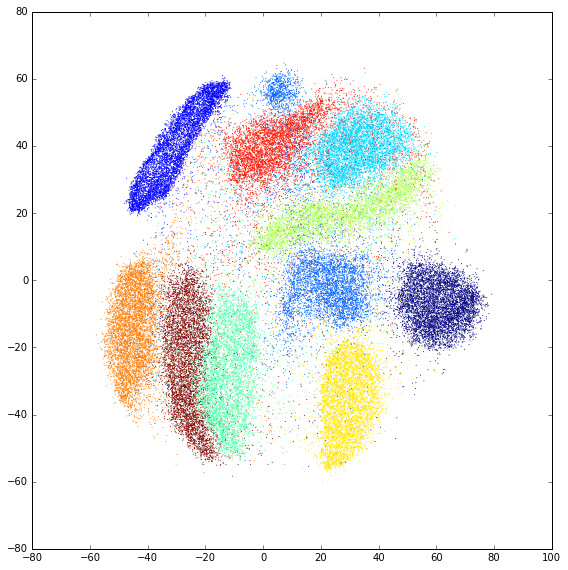

In [64]:
%time prediction = model.predict(X_train)
fig = plt.figure(figsize=(8,8))
plt.scatter(prediction[:,0], prediction[:,1], alpha=1, marker='o', s=1, edgecolor='', c=y_train)
ax = fig.gca()
ax.set_autoscale_on(False)
fig.tight_layout()

In [45]:
from keras.models import model_from_json
def save_model(model, name):
    json_string = model.to_json()
    open(name + '.json', 'w').write(json_string)
    model.save_weights(name + '.h5')
def load_model(name):
    model = model_from_json(open(name + '.json').read())
    model.load_weights(name + '.h5')

In [46]:
save_model(model, 'mnist t-SNE')

[WARNING] mnist t-SNE.h5 already exists - overwrite? [y/n]n


In [ ]:
# loaded = load_model('mnist t-SNE')